In [ ]:
!pip install pycryptodome --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.4 MB/s eta 0:00:00


In [ ]:
import hashlib
import hmac
import matplotlib.pyplot as plt
import numpy as np
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from skimage import io
from IPython.display import display
from google.colab import files



# Method Definitions




### Key Generation & Integrity Check

In [ ]:
# Geneartes Cryptographic Key (Default: AES-256) from User-Input using SHA-256 Hash Algorithm
def derive_key(userkey: str, bits: int = 256) -> bytes:
    return hashlib.sha256(userkey.encode()).digest()[:(bits//8)]

In [ ]:
# Append an HMAC tag (8 bytes) to encrypted data for integrity verification
def add_hmac(ciphertext: bytes, key: bytes) -> bytes:
    tag = hmac.new(key, ciphertext, hashlib.sha256).digest()[:8]
    return ciphertext + tag

In [ ]:
# Verifies HMAC tag of the data
def verify_hmac(ciphertext_with_tag: bytes, key: bytes) -> tuple[bool, bytes]:
    data = ciphertext_with_tag[:-8]
    tag = ciphertext_with_tag[-8:]
    expected = hmac.new(key, data, hashlib.sha256).digest()[:8]
    return hmac.compare_digest(tag, expected), data

### AES Encryption & Decryption

In [ ]:
# Encryption
def encrypt_message(message: str, userkey: str) -> bytes:
    key = derive_key(userkey)   # 32-byte key from SHA-256
    cipher = AES.new(key, AES.MODE_CBC) # Random IV generated internally
    ciphertext = cipher.encrypt(pad(message.encode(), AES.block_size))  # PKCS7 padding
    payload = cipher.iv + add_hmac(ciphertext, key) # Store IV + encrypted HMAC
    return payload

In [ ]:
# Decryption
def decrypt_message(payload: bytes, userkey: str) -> str:
    key = derive_key(userkey)
    iv = payload[:16]   # First 16 bytes are the IV
    ciphertext_with_tag = payload[16:]  # Rest is the ciphertext + HMAC
    valid, ciphertext = verify_hmac(ciphertext_with_tag, key)
    if not valid:
        raise ValueError("Integrity check failed. Possible wrong key or corrupted data.")
    cipher = AES.new(key, AES.MODE_CBC, iv)
    plaintext = unpad(cipher.decrypt(ciphertext), AES.block_size).decode()
    return plaintext

### Image Steganography (using Least Significant Bit)

In [ ]:
# Embed binary data into the LSBs of the image pixels.
# The first 32 bits encode the length of the actual data in bytes.
# Each byte is embedded using 8 bits into 8 consecutive pixel channels.
def embed_into_image(image: np.ndarray, data: bytes) -> np.ndarray:
    data_len = format(len(data), '032b')  # Convert integer to 32-bit binary string
    bin_data = data_len + ''.join(format(byte, '08b') for byte in data)
    total_bits = len(bin_data)

    flat_img = image.flatten()
    if total_bits > len(flat_img):
        raise ValueError("Image is too small to hold the data.")

    for i in range(total_bits):
        flat_img[i] = (int(flat_img[i]) & ~1) | int(bin_data[i])  # Clear LSB and set

    return flat_img.reshape(image.shape)

In [ ]:
# Extract binary data from LSBs of the image.
# First 32 bits give the data length (in bytes).
def extract_from_image(image: np.ndarray) -> bytes:
    flat_img = image.flatten()
    len_bits = ''.join(str(flat_img[i] & 1) for i in range(32))
    data_len = int(len_bits, 2)  # Convert 32-bit binary string to integer
    total_bits = data_len * 8

    bin_data = ''.join(str(flat_img[i + 32] & 1) for i in range(total_bits))
    return bytes(int(bin_data[i:i+8], 2) for i in range(0, total_bits, 8))

### Image Handlers

In [ ]:
# Predefined as Demo Image Source
DEFAULT_IMAGE_URL = 'https://i.pinimg.com/736x/b3/35/c2/b335c2b25fdd4059ca82eaee82ab543c.jpg'

In [ ]:
# Loading the Image
def load_image(source: str) -> np.ndarray:
    try:
        image = io.imread(source.strip())
    except Exception as e:
        return None

    return image

In [ ]:
# Displaying the Image
def display_image(image: np.ndarray, title: str = None) -> None:
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(
            f"{title}\n",
            fontdict = {'family': 'serif', 'size': 11, 'weight': 'bold', 'color': 'blue'}
        )
        plt.text(
            s = "{" + " × ".join(map(str, image.shape)) + "}",
            x = image.shape[1] / 2,
            y = -50,
            va = 'center',
            ha = 'center',
            fontdict = {
                'size': 9,
                'color': 'grey'
            }
        )
    plt.show()



---


# Main Execution Flow



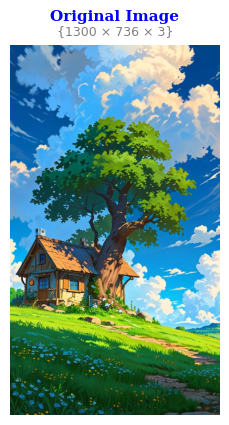

In [ ]:
# @title ### Step 1 — _`Define the source of "Cover Image" & "Preview" the image`_ {"run":"auto","vertical-output":true,"display-mode":"form"}

# @markdown > __`NOTE` :__ While using `Pre-defined` mode, the `Cover Image` does not need to be specified. So, you can Leave the input field as blank.

MODE = "Pre-defined" # @param ["Pre-defined","Image Path or URL"]
COVER_IMAGE = "" # @param {"type":"string","placeholder":"Local Image Path / Raw Image URL"}

try:
    if MODE == "Pre-defined":
        COVER_IMAGE = DEFAULT_IMAGE_URL

    image = load_image(COVER_IMAGE.strip())
    if image is None:
        raise ValueError("Cannot load the image with specified source...")

    display_image(image, "Original Image")

except ValueError as e:
    print(f"-<·ERROR·>- {str(e)}")

In [ ]:
# @title ### Step 2 — _`Define "Message" & "Password", to perform "Encryption"`_ {"run":"auto","vertical-output":true,"display-mode":"form"}

MESSAGE = "Hello, Cyber World! This is an encrypted message that can travel via image. How cool, isn't it!?" # @param {"type":"string","placeholder":"Secret Message"}
KEY = "8k15e42y7" # @param {"type":"string","placeholder":"Password"}

try:
    MESSAGE = MESSAGE.strip()
    if MESSAGE == "":
        MESSAGE = None
        raise ValueError("Message cannot be empty...")

    KEY = KEY.strip()
    if KEY == "":
        KEY = None
        raise ValueError("Key cannot be empty...")
    elif len(KEY) < 6:
        KEY = None
        raise ValueError("Key length should be 6 or higher...")

    # Encrypt the message
    encrypted_payload = encrypt_message(MESSAGE, KEY)
    print(f"-<৹>- Message encrypted successfully! (Password: {KEY})")
    print(f"-<৹>- NOTE: Please remember this 'Key' / 'Password' for decryption.")

except ValueError as e:
    print(f"-<·ERROR·>- {str(e)}")

-<৹>- Message encrypted successfully! (Password: 8k15e42y7)
-<৹>- NOTE: Please remember this 'Key' / 'Password' for decryption.


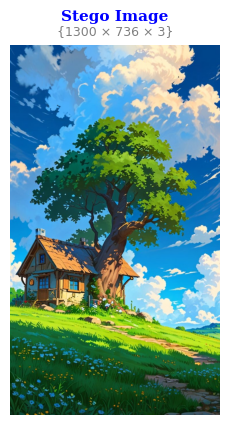

In [ ]:
# @title ### Step 3 — _`Embed the "Encrypted Message" into the "Cover Image"`_ {"run":"auto","display-mode":"form"}

# @markdown > `OPERATION` :
# @markdown > - __Save__ — This will save the `Stego Image` file into the `Local Storage` (In Google Colab, it's `Runtime Storage`).
# @markdown > - __Save & Download__ — This will also do the same, additionally it initiates downloading for the `Stego Image` file.

stego_image = embed_into_image(image.copy(), encrypted_payload)
display_image(stego_image, "Stego Image")

OPERATION = "Save (Stego Image)" # @param ["Save (Stego Image)","Save & Download (Stego Image)"]
io.imsave("stego_image.png", stego_image)

if OPERATION.startswith("Save & Download"):
    files.download("stego_image.png")

In [ ]:
# @title ### Step 4 — _`Extract & Decrypt the "Encryted Message" from "Stego Image" using "Key"`_ {"vertical-output":true,"display-mode":"form"}

MODE = "Default (Instance Variable)" # @param ["Default (Instance Variable)","Image Path or URL"]
IMAGE = "" # @param {"type":"string","placeholder":"Local Image Path / Raw Image URL"}
PASSWORD = "8k15e42y7" # @param {"type":"string","placeholder":"Key / Password"}

# Extraction
extracted_bytes: bytes = None
if MODE.startswith("Default"):
    extracted_bytes = extract_from_image(stego_image)
else:
    try:
        extracted_bytes = extract_from_image(load_image(IMAGE.strip()))
    except Exception as e:
        print(f"-<·ERROR·>- {str(e)}")

try:
    PASSWORD = PASSWORD.strip()
    if PASSWORD == "":
        raise ValueError("Key cannot be empty...")
    elif len(PASSWORD) < 6:
        PASSWORD = None
        raise ValueError("Key length should be 6 or higher...")
except ValueError as e:
    PASSWORD = None
    print(f"-<·ERROR·>- {str(e)}")

if PASSWORD is not None:
    # Decryption
    try:
        decrypted_message = decrypt_message(extracted_bytes, PASSWORD)
        print(f"-<<·DECRYPTED MESSAGE·>>- {decrypted_message}")
    except Exception as e:
        print(f"-<·DECTYPTION FAILED·>- {str(e)}")

-<<·DECRYPTED MESSAGE·>>- Hello, Cyber World! This is an encrypted message that can travel via image. How cool, isn't it!?
